In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes

In [4]:
import json
from datasets import Dataset

# Load dataset (adjust path as needed)
with open('/teamspace/studios/this_studio/nlp/arsarcasm_train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)  # For single JSON array

dataset = Dataset.from_list(data)
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")
print("Sample:", train_dataset[0])

Training samples: 11294
Evaluation samples: 1255
Sample: {'input': 'يا أيها المغيبون', 'is_sarcastic': True, 'sentiment': 'NEG', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [5]:
print(f"Total examples: {len(dataset['train']) + len(dataset['test'])}")
print("First example:", dataset['train'][0])

Total examples: 12549
First example: {'input': 'يا أيها المغيبون', 'is_sarcastic': True, 'sentiment': 'NEG', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [6]:
# 4. Create multi-task prompt template
def formatting_prompts_func(examples):
    instructions = []
    inputs = []
    outputs = []
    
    for input_text, sarc_inst, sent_inst, dial_inst, sarcasm, sentiment, dialect in zip(
        examples["input"],
        examples["sarcasm_instruction"],
        examples["sentiment_instruction"],
        examples["dialect_instruction"],
        examples["is_sarcastic"],
        examples["sentiment"],
        examples["dialect"],
    ):
        # Combined instruction for all tasks
        combined_instruction = (
            f"Perform all these tasks for the Arabic text:\n"
            f"1. {sarc_inst}\n"
            f"2. {sent_inst}\n"
            f"3. {dial_inst}\n\n"
            f"Text: {input_text}\n\n"
            "Respond with EXACTLY this format:\n"
            "Sarcasm: TRUE/FALSE\n"
            "Sentiment: POS/NEG/NEU\n"
            "Dialect: msa/egypt/gulf/levant/magreb"
        )
        
        # Combined output
        combined_output = (
            f"Sarcasm: {'TRUE' if sarcasm else 'FALSE'}\n"
            f"Sentiment: {sentiment}\n"
            f"Dialect: {dialect}"
        )
        
        instructions.append(combined_instruction)
        inputs.append(input_text)
        outputs.append(combined_output)
    
    return {"text": [f"### Instruction:\n{i}\n\n### Input:\n{x}\n\n### Response:\n{y}" 
                    for i, x, y in zip(instructions, inputs, outputs)]}

# Apply formatting
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched=True)


Map:   0%|          | 0/11294 [00:00<?, ? examples/s]

Map:   0%|          | 0/1255 [00:00<?, ? examples/s]

In [8]:
# 5. Load model
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Qwen3-8B-Base",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

# Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                  "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing=True,
    random_state=3407,
    max_seq_length=2048,
)

==((====))==  Unsloth 2025.4.1: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/32.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.71k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

Unsloth: Making `model.base_model.model.model` require gradients


In [10]:
# 6. Training setup
from transformers import TrainingArguments

trainer_args = TrainingArguments(
    per_device_train_batch_size=4,               # Can try 5–6 if memory allows
    gradient_accumulation_steps=2,               # Reduces total steps, speeds training
    warmup_ratio=0.03,                           # Better for small training runs than fixed steps
    max_steps=1000,
    learning_rate=3e-5,                          # Slightly higher LR helps LoRA converge faster
    fp16=False,
    bf16=True,                                   # Use bf16 if supported (you have 24GB, so likely yes)
    logging_steps=10,
    optim="paged_adamw_8bit",                    # More memory-efficient than adamw_8bit
    weight_decay=0.05,                           # Slightly higher decay can help generalization
    lr_scheduler_type="cosine",                  # Often outperforms linear for longer runs
    seed=3407,
    output_dir="outputs",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    report_to="none",                            # Optional: avoid unnecessary logging overhead
    save_total_limit=2,                          # Prevent filling disk
)

# 7. Create trainer
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=trainer_args,
    max_seq_length=1024,
)


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/11294 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1255 [00:00<?, ? examples/s]

In [11]:
# 8. Train!
trainer.train()

# 9. Save model
model.save_pretrained("qwen3_arabic_multitask")
tokenizer.save_pretrained("qwen3_arabic_multitask")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11,294 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 43,646,976/8,000,000,000 (0.55% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,0.513600,0.483067
200,0.459300,0.462453
300,0.462200,0.459636
400,0.490000,0.458164
500,0.448500,0.454715
600,0.451100,0.452808
700,0.468800,0.451833
800,0.496800,0.450714
900,0.495200,0.450282
1000,0.455100,0.450654


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


('qwen3_arabic_multitask/tokenizer_config.json',
 'qwen3_arabic_multitask/special_tokens_map.json',
 'qwen3_arabic_multitask/vocab.json',
 'qwen3_arabic_multitask/merges.txt',
 'qwen3_arabic_multitask/added_tokens.json',
 'qwen3_arabic_multitask/tokenizer.json')

In [12]:
# 1. First authenticate with Hugging Face
from huggingface_hub import notebook_login
notebook_login()

Token has not been saved to git credential helper.


In [13]:
# 2. Push model and tokenizer to public repository
model.push_to_hub(
    "omarwaleed523/qwen3-8b-arabic-multitask",
    private=False,  # Make repository public
    create_pr=False,  # Directly push to main (since new repo)
)

tokenizer.push_to_hub(
    "omarwaleed523/qwen3-8b-arabic-multitask",
    private=False,
    create_pr=False,
)

print("Model successfully pushed to: https://huggingface.co/omarwaleed523/qwen3-8b-arabic-multitask")

README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/175M [00:00<?, ?B/s]

Saved model to https://huggingface.co/omarwaleed523/qwen3-8b-arabic-multitask


tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Model successfully pushed to: https://huggingface.co/omarwaleed523/qwen3-8b-arabic-multitask


In [3]:
!pip install seaborn

In [1]:
pip install accelerate

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from accelerate import Accelerator
from datasets import Dataset
import json
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
# Initialize Accelerator for multi-device or efficient model handling
accelerator = Accelerator()

# Load tokenizer and model with mixed precision (FP16) and device placement
model_name = 'omarwaleed523/qwen3-8b-arabic-multitask'

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')  # Set padding_side='left'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to("cuda")

# Prepare model with Accelerator for efficient inference
model = accelerator.prepare(model)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# Load test dataset
with open('/teamspace/studios/this_studio/nlp/arsarcasm_test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

test_dataset = Dataset.from_list(test_data)
print(f"Test samples: {len(test_dataset)}")
print("Sample:", test_dataset[0])

Test samples: 3000
Sample: {'input': 'اخوي حانق يالغلا وشفيك معصب عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان', 'is_sarcastic': False, 'sentiment': 'NEG', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': ''}


In [4]:
# Alpaca-style prompt template 
alpaca_prompt = """### Instruction:
{instruction}

### Input:
{input}

### Response:
"""

def create_prompt(examples):
    prompts = []
    for input_text, sarc_inst, sent_inst, dial_inst in zip(
        examples["input"],
        examples["sarcasm_instruction"],
        examples["sentiment_instruction"],
        examples["dialect_instruction"],
    ):
        # Combine instructions for all tasks
        combined_instruction = (
            f"Perform all these tasks for the Arabic text:\n"
            f"1. {sarc_inst}\n"
            f"2. {sent_inst}\n"
            f"3. {dial_inst}\n\n"
            "Respond with EXACTLY this format:\n"
            "Sarcasm: TRUE/FALSE\n"
            "Sentiment: POS/NEG/NEU\n"
            "Dialect: msa/egypt/gulf/levant/magreb"
        )
        
        # Create the full prompt
        prompt = alpaca_prompt.format(instruction=combined_instruction, input=input_text, output="")
        prompts.append(prompt)
    
    return {"prompt": prompts}

# Apply the prompt formatting to the test dataset and ensure it's done in batch
test_dataset = test_dataset.map(create_prompt, batched=True)

# Check the output structure
print(test_dataset[0])  # Verify that "prompt" key is present

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'input': 'اخوي حانق يالغلا وشفيك معصب عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان', 'is_sarcastic': False, 'sentiment': 'NEG', 'dialect': 'msa', 'sarcasm_instruction': "Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.", 'sentiment_instruction': "Classify the sentiment of the given Arabic text. Return ONLY one of these labels: 'POS', 'NEG', or 'NEU' with no additional text or explanation.", 'dialect_instruction': "Identify the Arabic dialect in the given text. Return ONLY one of these labels: 'msa', 'egypt', 'gulf', 'levant', or 'magreb' with no additional text or explanation.", 'predicted_sarcasm': '', 'predicted_sentiment': '', 'predicted_dialect': '', 'prompt': "### Instruction:\nPerform all these tasks for the Arabic text:\n1. Analyze if the given Arabic text contains sarcasm. Return ONLY 'TRUE' or 'FALSE' with no additional text or explanation.\n2. Classify the sentiment of the given Arabic text. R

In [5]:
# Function to clean the 'human' suffix from dialect predictions
def clean_dialect(dialect):
    return re.sub(r'(?i)human$', '', dialect)  # Remove 'human' regardless of case

# Optimized inference function with batch processing
def batch_inference(test_dataset, batch_size=8):
    batched_input = [sample["prompt"] for sample in test_dataset]  # Extract "prompt" from the dataset
    num_batches = len(batched_input) // batch_size + (len(batched_input) % batch_size != 0)

    predictions = []
    for i in tqdm(range(num_batches), desc="Inference Progress", unit="batch"):
        batch_input = batched_input[i * batch_size: (i + 1) * batch_size]
        inputs = tokenizer(batch_input, return_tensors="pt", padding=True, truncation=True).to("cuda")

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Clean predictions and store
        for output in decoded_output:
            sarcasm, sentiment, dialect = parse_model_output(output)
            predictions.append((sarcasm, sentiment, clean_dialect(dialect)))
    
    return predictions

# Function to parse model output
def parse_model_output(output):
    # Initialize default values
    sarcasm, sentiment, dialect = "ERROR", "ERROR", "ERROR"
    
    # Split the output into lines
    lines = output.split("\n")
    
    # Extract values based on keywords
    for line in lines:
        if line.startswith("Sarcasm:"):
            sarcasm = line.split("Sarcasm:")[1].strip()
        elif line.startswith("Sentiment:"):
            sentiment = line.split("Sentiment:")[1].strip()
        elif line.startswith("Dialect:"):
            dialect = line.split(":")[1].strip()
    
    return sarcasm, sentiment, dialect


In [6]:
# Run inference on the full dataset
predictions = batch_inference(test_dataset, batch_size=8)

Inference Progress:   0%|          | 0/375 [00:00<?, ?batch/s]

Inference Progress: 100%|██████████| 375/375 [27:27<00:00,  4.39s/batch]


Sarcasm Confusion Matrix:


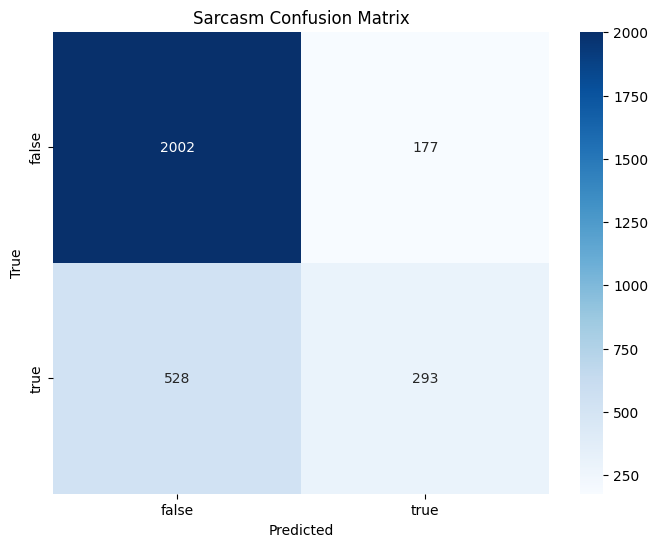

Sarcasm Classification Report:
              precision    recall  f1-score   support

       false       0.79      0.92      0.85      2179
        true       0.62      0.36      0.45       821

    accuracy                           0.77      3000
   macro avg       0.71      0.64      0.65      3000
weighted avg       0.75      0.77      0.74      3000

Sarcasm Overall F1 Score: 0.74
Sentiment Confusion Matrix:


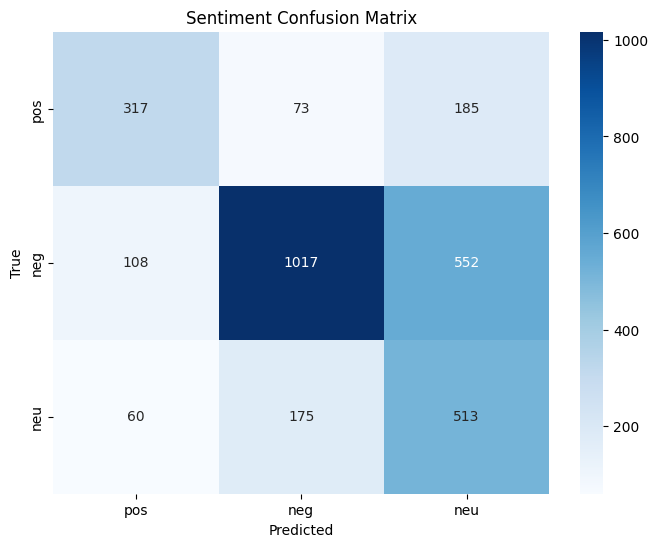

Sentiment Classification Report:
              precision    recall  f1-score   support

         pos       0.65      0.55      0.60       575
         neg       0.80      0.61      0.69      1677
         neu       0.41      0.69      0.51       748

    accuracy                           0.62      3000
   macro avg       0.62      0.61      0.60      3000
weighted avg       0.68      0.62      0.63      3000

Sentiment Overall F1 Score: 0.63
Dialect Confusion Matrix:


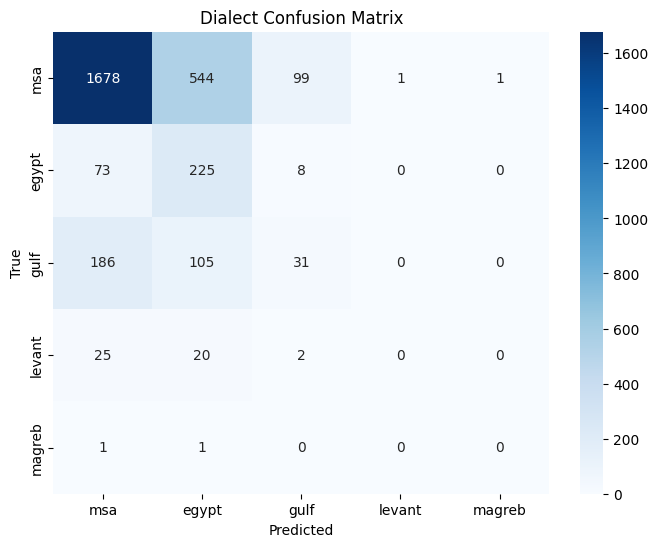

Dialect Classification Report:
              precision    recall  f1-score   support

         msa       0.85      0.72      0.78      2323
       egypt       0.25      0.74      0.37       306
        gulf       0.22      0.10      0.13       322
      levant       0.00      0.00      0.00        47
      magreb       0.00      0.00      0.00         2

    accuracy                           0.64      3000
   macro avg       0.27      0.31      0.26      3000
weighted avg       0.71      0.64      0.66      3000

Dialect Overall F1 Score: 0.66


In [7]:
# Extract true labels for comparison
true_labels = [
    ("TRUE" if sample["is_sarcastic"] else "FALSE", sample["sentiment"], sample["dialect"])
    for sample in test_dataset
]

# Normalize values to handle case-insensitivity
true_labels = [(sarc.lower(), sent.lower(), dial.lower()) for sarc, sent, dial in true_labels]
predictions = [(sarc.lower(), sent.lower(), dial.lower()) for sarc, sent, dial in predictions]

# Separate filtered predictions and true labels for each task
true_sarcasm, pred_sarcasm = zip(*[(true[0], pred[0]) for true, pred in zip(true_labels, predictions)])
true_sentiment, pred_sentiment = zip(*[(true[1], pred[1]) for true, pred in zip(true_labels, predictions)])
true_dialect, pred_dialect = zip(*[(true[2], pred[2]) for true, pred in zip(true_labels, predictions)])

# Specify all possible labels for each task
sarcasm_labels = ["false", "true"]
sentiment_labels = ["pos", "neg", "neu"]
dialect_labels = ["msa", "egypt", "gulf", "levant", "magreb"]

# Function to plot confusion matrix using Seaborn
def plot_confusion_matrix(true_labels, pred_labels, labels, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluation and metrics for Sarcasm, Sentiment, and Dialect
def evaluate_metrics(true_sarcasm, pred_sarcasm, true_sentiment, pred_sentiment, true_dialect, pred_dialect):
    # Sarcasm Evaluation
    print("Sarcasm Confusion Matrix:")
    plot_confusion_matrix(true_sarcasm, pred_sarcasm, sarcasm_labels, "Sarcasm Confusion Matrix")

    print("Sarcasm Classification Report:")
    print(classification_report(true_sarcasm, pred_sarcasm, labels=sarcasm_labels, target_names=sarcasm_labels, zero_division=0))
    
    f1_sarcasm = f1_score(true_sarcasm, pred_sarcasm, labels=sarcasm_labels, average="weighted", zero_division=0)
    print(f"Sarcasm Overall F1 Score: {f1_sarcasm:.2f}")

    # Sentiment Evaluation
    print("Sentiment Confusion Matrix:")
    plot_confusion_matrix(true_sentiment, pred_sentiment, sentiment_labels, "Sentiment Confusion Matrix")

    print("Sentiment Classification Report:")
    print(classification_report(true_sentiment, pred_sentiment, labels=sentiment_labels, target_names=sentiment_labels, zero_division=0))

    f1_sentiment = f1_score(true_sentiment, pred_sentiment, labels=sentiment_labels, average="weighted", zero_division=0)
    print(f"Sentiment Overall F1 Score: {f1_sentiment:.2f}")

    # Dialect Evaluation
    print("Dialect Confusion Matrix:")
    plot_confusion_matrix(true_dialect, pred_dialect, dialect_labels, "Dialect Confusion Matrix")

    print("Dialect Classification Report:")
    print(classification_report(true_dialect, pred_dialect, labels=dialect_labels, target_names=dialect_labels, zero_division=0))

    f1_dialect = f1_score(true_dialect, pred_dialect, labels=dialect_labels, average="weighted", zero_division=0)
    print(f"Dialect Overall F1 Score: {f1_dialect:.2f}")

# Run evaluation on the full dataset
evaluate_metrics(true_sarcasm, pred_sarcasm, true_sentiment, pred_sentiment, true_dialect, pred_dialect)